# Imports

In [73]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable

# Hidrogen Atom

We will start by studying the Hydrogen Atom:

$$
\begin{align*}

H &= -\frac12\nabla^2 - \frac1r
\\\\


\psi(\textbf r) &= e^{-\beta r}

\end{align*}
$$

# Metropolis Sampling Position

In [74]:
def rvec(pos: np.ndarray) -> float:
    return np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)


def r3(x: float, y: float, z:float) -> float:
    return np.sqrt(x**2 + y**2 + z**2)


def samplePos(M: int, beta: float, delta: float = 0.5, Mmulti: int = 10) -> np.ndarray:
    """
        Samples M positions taking as the desired distribution psi, assuming psi is real!
    """

    # List of samples
    samples = np.zeros((M), dtype=float)

    # Starting position
    x, y, z = 10, 0.1, 0.01
    rpos = r3(x, y, z)
    samples[0] = rpos

    logpsi = -beta * rpos

    # Metropolis Loop
    succ = 0
    for attempt in range(M-1):
        xp = x + delta*(np.random.random() - 0.5)
        yp = y + delta*(np.random.random() - 0.5)
        zp = z + delta*(np.random.random() - 0.5)

        rposp = r3(xp, yp, zp)
        logpsip = -beta * rposp

        accept = min(1, np.exp(2 * (logpsip - logpsi)))

        # Accept step
        if accept > np.random.random():
            succ += 1

            x, y, z = xp, yp, zp
            rpos = rposp
            logpsi = logpsip
        
        # Save state
        samples[attempt+1] = rpos
    
    print(f"Acceptance: {succ / attempt}")
    return samples

In [75]:
def sampleNeff(data: np.ndarray, k1percent: float = 0.0, ipercent: float = 0.4) -> int:
    N = len(data)
    k1 = int(k1percent * N)
    k2 = N-1

    icutoff = int(k2 * ipercent)
    Neq = k2 - k1 + 1

    # Calculate Stats
    ave = np.mean(data)
    var = np.var(data, mean=ave, ddof=1)

    autocorr = np.array([np.sum((data[k1: k2-i]-ave) * (data[k1 + i: k2]-ave)) for i in range(1, Neq)]) / (var * (Neq - 1))
    timecorr = 1 + 2 * np.sum(autocorr[:icutoff] * (autocorr[:icutoff] > 0))

    Neff = Neq / timecorr
    print(f"Neff: {Neff}")

    return Neff

## No Reweighting

Beta = 0.200
Acceptance: 0.8154420589411921
Neff: 54.926488949712365
Energy = -0.18720181753980233
Variance on Energy = 0.021370124928665756

Beta = 0.300
Acceptance: 0.7233631150820109
Neff: 66.98371565977449
Energy = -0.265073774824804
Variance on Energy = 0.028779659341372936

Beta = 0.400
Acceptance: 0.6494199226563542
Neff: 97.05016741543608
Energy = -0.31063930774102316
Variance on Energy = 0.021435834169252523

Beta = 0.500
Acceptance: 0.5780104013868516
Neff: 111.72695447451154
Energy = -0.37660654924107884
Variance on Energy = 0.024175847027167872

Beta = 0.600
Acceptance: 0.5182691025470063
Neff: 96.15319424723485
Energy = -0.4105870093311295
Variance on Energy = 0.02364824437659328

Beta = 0.700
Acceptance: 0.4554607280970796
Neff: 124.73099192167719
Energy = -0.44606717091152664
Variance on Energy = 0.014545522206961037

Beta = 0.800
Acceptance: 0.40218695826110146
Neff: 129.56594575291396
Energy = -0.46899378367971334
Variance on Energy = 0.010563570881319187

Beta = 0.900

Text(0.5, 1.0, 'Parameter Sweep')

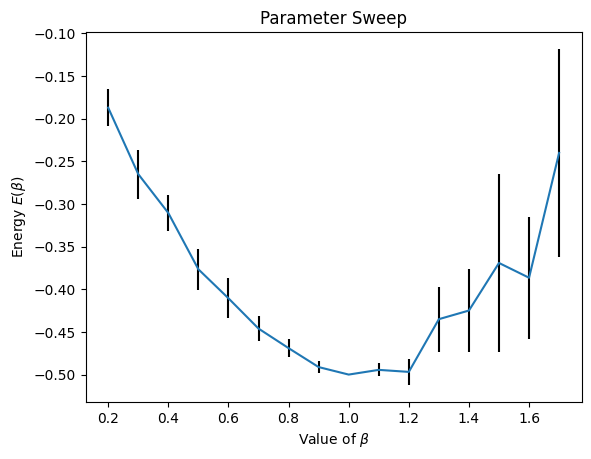

In [76]:
# Parameters
sampleM = 15000
discard = 1500

# Sweep Variational Parameter
betamin = 0.2
betamax = 1.7

Ebeta = []
Estd = []
bb = np.linspace(betamin, betamax, 16)
for beta in bb:
    print(f"Beta = {beta:.3f}")
    Rs = samplePos(sampleM, beta, delta=4, Mmulti=20)
    Rs = Rs[discard:]
    Neff = sampleNeff(Rs)
    El = -0.5*beta*(beta - 2/Rs) - 1.0 / Rs

    Estd += [np.std(El) / np.sqrt(Neff)]
    Ebeta += [np.average(El)]
    print(f"Energy = {Ebeta[-1]}")
    print(f"Variance on Energy = {Estd[-1]}")
    print("")

print(f"Best beta: {bb[Ebeta.index(np.min(Ebeta))]}")
plt.errorbar(bb, Ebeta, yerr=Estd, ecolor="black")
plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Parameter Sweep")

# With Reweighting (Not Working!)

In [94]:
# Parameters
sampleM = 100000
discard = 5000
gamma = 0.03           # Gradient descent constant

# Starting Variational Parameters
beta0 = 1.1
beta1 = 1.2

delta0 = 1/beta
delta1 = 1/beta1

bb = [beta0, beta1]
Ebeta = []
Estd = []

# Want to minimize a function which is average(energy) + varW * std(energy) 
stdW = 0.1

# First run
beta = beta0
delta = delta0
Rs = samplePos(sampleM, beta, delta)
Rs = Rs[discard:]
El = -0.5*beta*(beta - 2/Rs) - 1.0 / Rs
Estd += [np.std(El) / np.sqrt(len(Rs))]
Ebeta += [np.average(El)]
func0 = np.average(El) + stdW * np.std(El) / np.sqrt(sampleM)

beta = beta1
delta = delta1
Rs = samplePos(sampleM, beta, delta)
Rs = Rs[discard:]
El = -0.5*beta*(beta - 2/Rs) - 1.0 / Rs
Estd += [np.std(El) / np.sqrt(len(Rs))]
Ebeta += [np.average(El)]
func1 = np.average(El) + stdW * np.std(El) / np.sqrt(sampleM)

while True:
    # Do gradient descent
    grad = (func1 - func0) / (beta1 - beta0)
    if 0.002 < abs(grad) < 0.01:
        grad *= 10
    step = - gamma * grad
    beta2 = beta1 + step

    # Calculate weights
    ww = np.exp(-2 * beta2 * Rs) / np.exp(-2 * beta1 * Rs)

    # Effective points should be high enough
    m = ((np.sum(ww))**2 / np.sum(ww**2)) / len(Rs)

    print(f"{grad:.3f}, {beta0:.3f}, {beta1:.3f}, {beta2:.3f}")
    if m < 0.5:
        break

    # New energy
    El = -(beta**2 - 2 * beta / Rs) / 2 - 1 / Rs
    bb += [beta2]
    Estd += [np.std(El) / np.sqrt(sampleM)]
    Ebeta += [(np.sum(El * ww)) / (np.sum(ww))]
    func2 = Ebeta[-1] + stdW * np.std(El) / np.sqrt(sampleM)

    # Next step
    beta0 = beta1
    beta1 = beta2

    func0 = func1
    func1 = func2

    if abs(grad) < 0.001:
        break

print(f"Final beta: {beta1}")

plt.scatter(bb, Ebeta)
plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Parameter Sweep")

Acceptance: 0.7855157103142063
Acceptance: 0.7687953759075181
0.144, 1.100, 1.200, 1.196
0.203, 1.200, 1.196, 1.190
0.058, 1.196, 1.190, 1.188
-0.501, 1.190, 1.188, 1.203
0.226, 1.188, 1.203, 1.196
0.651, 1.203, 1.196, 1.177
0.132, 1.196, 1.177, 1.173
-0.795, 1.177, 1.173, 1.196
0.236, 1.173, 1.196, 1.189
0.884, 1.196, 1.189, 1.163
0.149, 1.189, 1.163, 1.158
-1.003, 1.163, 1.158, 1.188
0.232, 1.158, 1.188, 1.181
1.076, 1.188, 1.181, 1.149
0.159, 1.181, 1.149, 1.144
-1.170, 1.149, 1.144, 1.180
0.230, 1.144, 1.180, 1.173
1.232, 1.180, 1.173, 1.136
0.165, 1.173, 1.136, 1.131
-1.312, 1.136, 1.131, 1.170
0.228, 1.131, 1.170, 1.163
1.368, 1.170, 1.163, 1.122
0.169, 1.163, 1.122, 1.117
-1.438, 1.122, 1.117, 1.160
0.226, 1.117, 1.160, 1.153
1.489, 1.160, 1.153, 1.109
0.172, 1.153, 1.109, 1.104
-1.552, 1.109, 1.104, 1.150
0.225, 1.104, 1.150, 1.143
1.600, 1.150, 1.143, 1.095
0.175, 1.143, 1.095, 1.090
-1.658, 1.095, 1.090, 1.140
0.224, 1.090, 1.140, 1.133
1.703, 1.140, 1.133, 1.082
0.176, 1.133

KeyboardInterrupt: 